# Introduction

You should have a database created from pasing one of the zip files hosted by HHS.



In [1]:
from sqlalchemy import engine_from_config, func
from sqlalchemy.orm import sessionmaker
from hornstone.alchemy import Base
import us
from datetime import timedelta, date, datetime
import calendar

from revaers.models import Data, VaxData
from revaers.query import get_vax_manus, base_cvquery, cvreports_until
from revaers.query import csv_update_backlog, get_csvdates

import numpy as np
import plotly.io as pio
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf

plt.style.use('dark_background')
one_day = timedelta(days=1)
today = date.today()
enddate = date(2021, 1, 1)


In [2]:

dburl = 'postgresql+psycopg2://dbadmin@localhost/revaers'
settings = {'sqlalchemy.url': dburl}
engine = engine_from_config(settings)
Base.metadata.create_all(engine)
Session = sessionmaker()
Session.configure(bind=engine)


In [3]:
s = Session()

def get_vtype_counts(session, enddate):
    vtypes = get_vax_manus(session, enddate)
    counts = dict()
    for manu in vtypes:
        query = cvreports_until(session, enddate)
        query = query.filter(VaxData.vax_manu == manu)
        counts[manu] = query.count()
    return counts

In [4]:
s.query(Data).count()


347616

In [5]:

def make_data_frame(query):
    return pd.read_sql(query.statement, query.session.bind)


<BarContainer object of 3 artists>

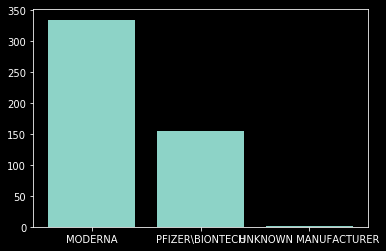

In [6]:
c = get_vtype_counts(s, enddate)
c.keys()
c.values()
plt.bar(c.keys(), c.values())


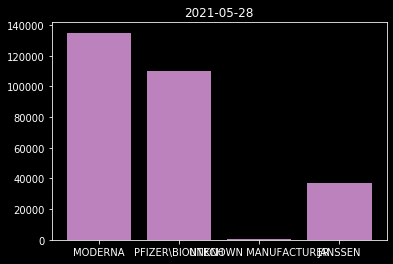

{'JANSSEN': 36971, 'MODERNA': 135045, 'PFIZER\\BIONTECH': 110291, 'UNKNOWN MANUFACTURER': 839}


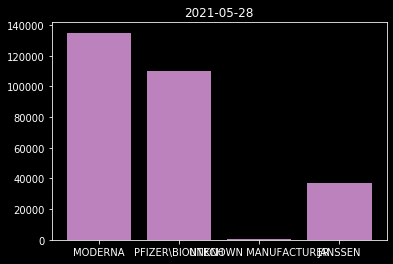

In [7]:
from IPython.display import display, clear_output

fig, ax = plt.subplots()

index_date = enddate
last_report_date = s.query(func.max(Data.recvdate)).one()[0]
while index_date <= last_report_date:
    counts = get_vtype_counts(s, index_date)
    clear_output(wait=True)
    ax.bar(counts.keys(), counts.values())
    ax.set_title(index_date)
    display(fig)
    print(counts)
    index_date += one_day

In [7]:
plt.show()
index_date

NameError: name 'index_date' is not defined

In [8]:
q = s.query(func.count(Data.vaers_id).label('Events'), Data.csvdate).group_by(Data.csvdate).order_by(Data.csvdate) 


In [9]:
df = make_data_frame(q)

In [10]:
df

,Events,csvdate
0,5351,2021-02-19
1,3958,2021-02-26
2,11309,2021-03-12
3,7389,2021-03-19
4,6180,2021-03-26
5,6266,2021-04-02
6,5826,2021-04-09
7,11495,2021-04-16
8,17743,2021-04-23
9,32844,2021-04-30


In [13]:
q = s.query(func.count(Data.vaers_id).label('events'),
            func.extract('month', Data.recvdate).label('month'))
q = q.filter(Data.csvdate == '2021-06-18')
q = q.group_by(func.extract('month', Data.recvdate))
q = q.order_by('month')

q = csv_update_backlog(s, date(2021, 6, 18))

data = dict()
months = list()
for events, month in q:
    m = calendar.month_name[int(month)]
    data[m] = events
    months.append(m)

    
df  = pd.DataFrame(dict(month=data.keys(), events=data.values()))

In [14]:
data

{'January': 140,
 'February': 62,
 'March': 84,
 'April': 18509,
 'May': 1041,
 'June': 10297}

In [13]:
first = s.query(func.min(Data.vaers_id)).one()[0]
last = s.query(func.max(Data.vaers_id)).one()[0]
identified = last - first
reported = s.query(Data).count()
unreported = identified - reported

print(identified, reported, unreported)


475532 347616 127916


In [15]:
df

,month,events
0,January,140
1,February,62
2,March,84
3,April,18509
4,May,1041
5,June,10297


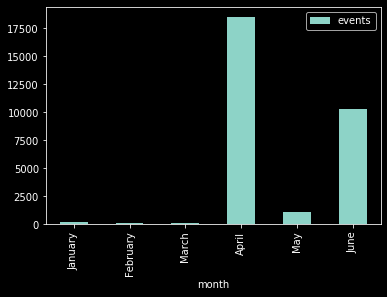

In [16]:
df.plot.bar(x='month')


In [17]:
pilots = s.query(Data).filter(Data.symptom_text.ilike('%pilot%'))
pdf = make_data_frame(pilots)


In [26]:
backlogs = dict()

for csvdate in get_csvdates(s):
    #print(csvdate)
    q = csv_update_backlog(s, csvdate)
    data = dict()
    for events, month in q:
        mname = calendar.month_name[int(month)]
        #print(events, mname)
        data[mname] = events
    backlogs[csvdate] = pd.DataFrame(dict(month=data.keys(), 
                                          events=data.values()))
    

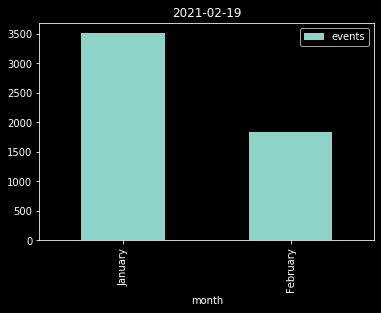

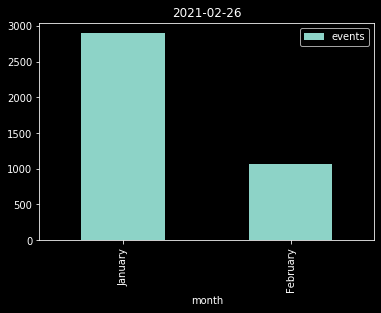

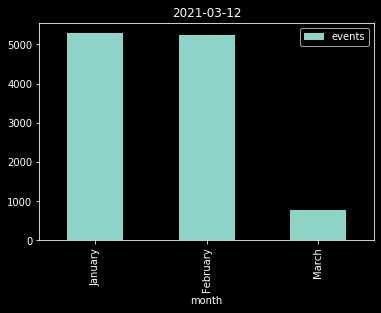

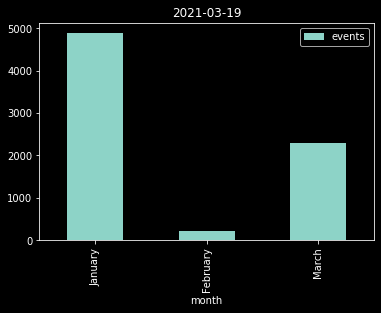

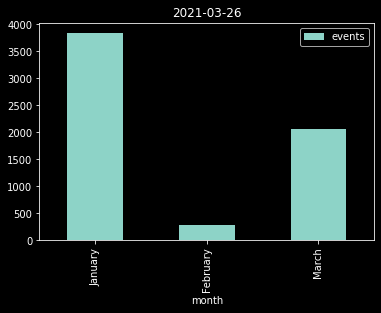

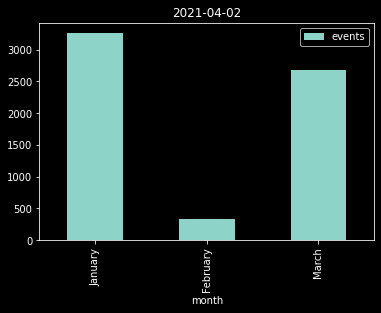

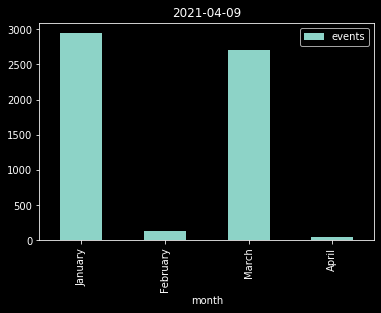

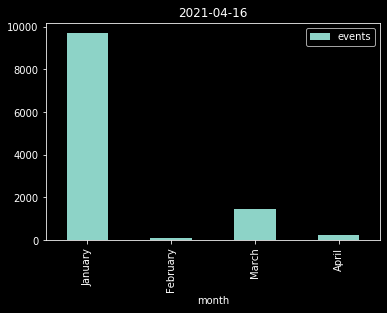

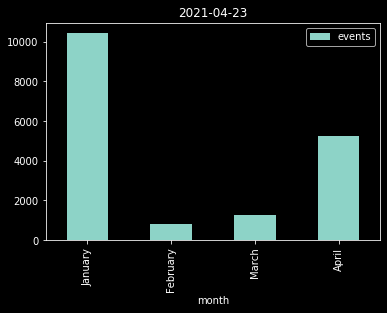

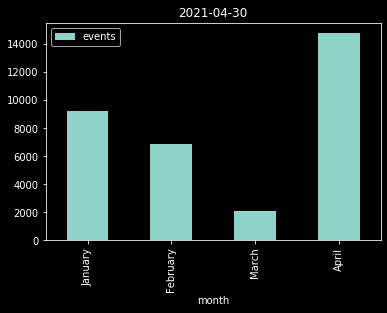

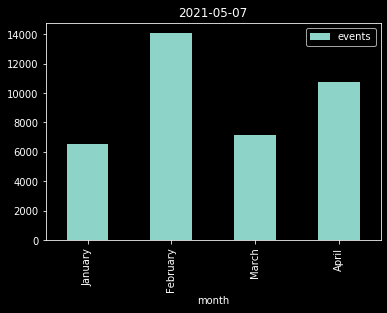

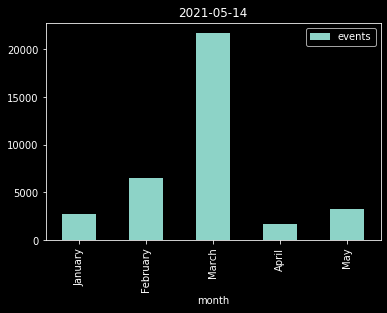

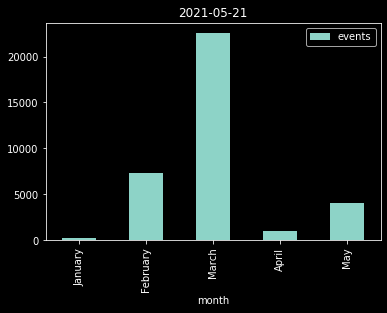

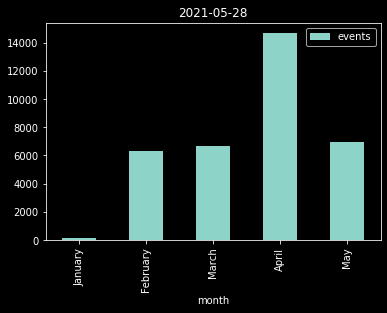

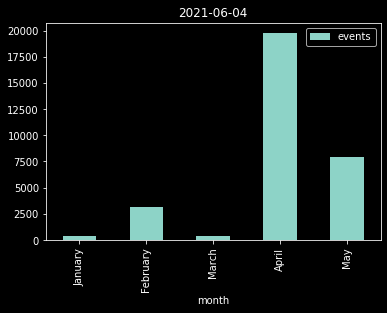

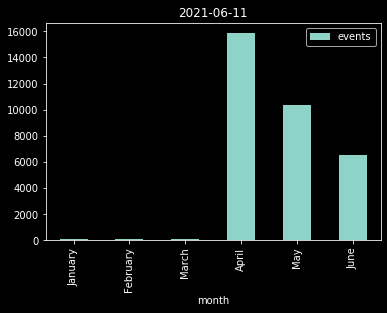

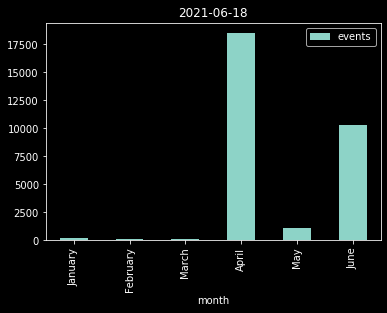

In [30]:
for csvdate, df in backlogs.items():
    df.plot.bar(x='month', title=csvdate)
